In [221]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Data Exploration

In [313]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69

def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    print(df['bus_stop_name'].unique())
    df.head()
    return df

In [316]:
def add_extra_data(route):
    if r == "6":
        b_6 = pd.read_csv("data/6 03-05-20.csv")
        b_6.loc[b_6['arrived'] == 1, 'arrived'] = True
        b_6 = b_6[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data["6"] = b_6
        return
    more = pd.read_csv("data/" + route + " 22-04-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [317]:
for r in routes:
    add_extra_data(r)

In [318]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (49220, 6)
["Ladbroke Grove Sainsbury's" 'Silverthorne Road'
 'Knightsbridge Station  / Harrods' 'Prince Of Wales Gate' 'Ladbroke Road'
 'Notting Hill Gate Station' 'Pont Street' 'Knightsbridge Station'
 'Kensington Church Street / Holland St' 'Vauxhall Bus Station'
 'Battersea Park Station' 'Cedars Road' 'Kilburn Lane / Harrow Road'
 'Kensal House' 'Ladbroke Grove Station' "Queen's Gate" 'Sopwith Way'
 'Queenstown Road / Wandsworth Road' 'Sheffield Terrace' 'Chesterton Road'
 'Union Road' 'The Chase' 'Kensal Rise Station'
 'Sloane Street / Knightsbridge Station' 'Battersea Park / Chelsea Gate'
 'Royal Albert Hall' 'Wandsworth Road Station' 'Rutland Gardens'
 'Queenstown Road Station' 'Royal Hospital Road' 'Knightsbridge Barracks'
 'Barlby Road' 'Prairie Street' 'Covent Garden Market East Side'
 'Larkhall Park' 'Lister Hospital' 'Harrow Road / Kilburn Lane'
 'Banister Road' 'Stanley Gardens' 'Palace Gate' 'St Charles Square'
 'Lansdowne Green' 'Sloane Square Stn

In [319]:
def spread_of_time(df, route):
    hour_min = [x[11:15] + '0' for x in df['expected_arrival']]
    for_aggr = df.assign(hour_min = hour_min)
    for_aggr = for_aggr.groupby('hour_min').count().reset_index()

    arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.scatter(arrival_times, for_aggr['bus_stop_name'])
    ax.set_title("Spread of time of data collected for bus route {}".format(route))
    ax.set_xlim(dt.datetime.strptime('00:00', '%H:%M'), dt.datetime.strptime('23:59', '%H:%M'))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Occurences")
    plt.show()

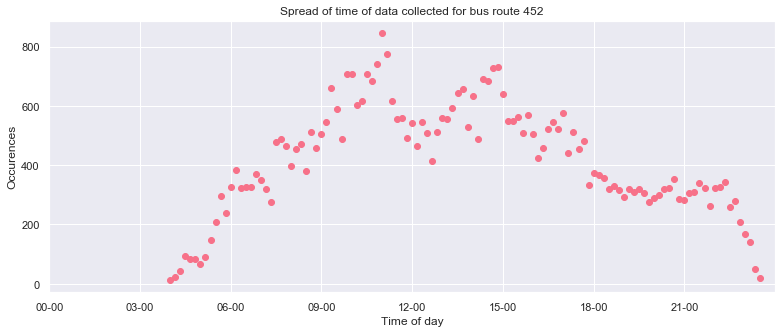

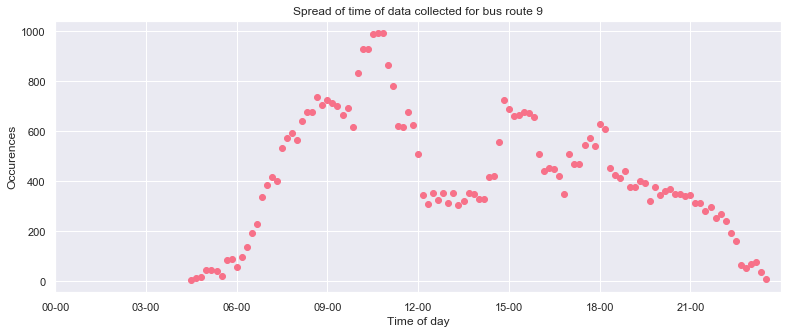

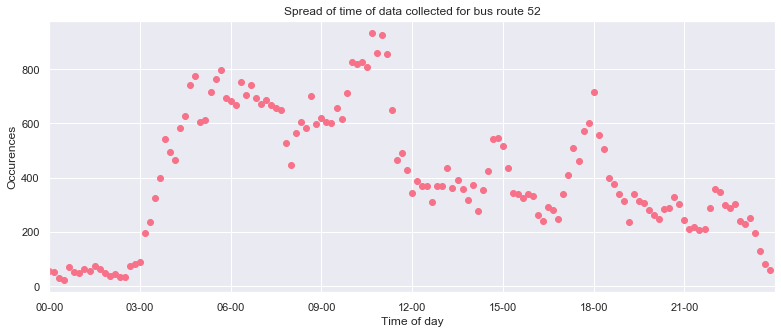

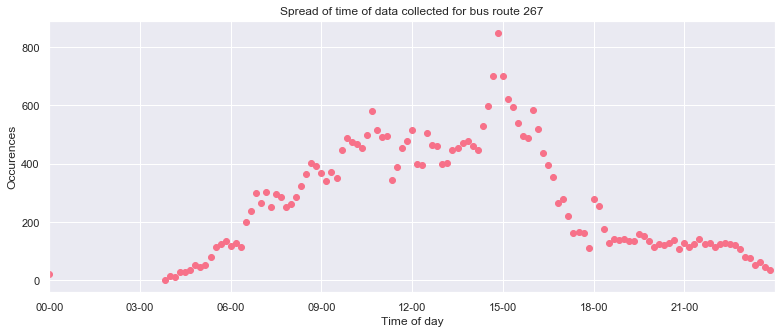

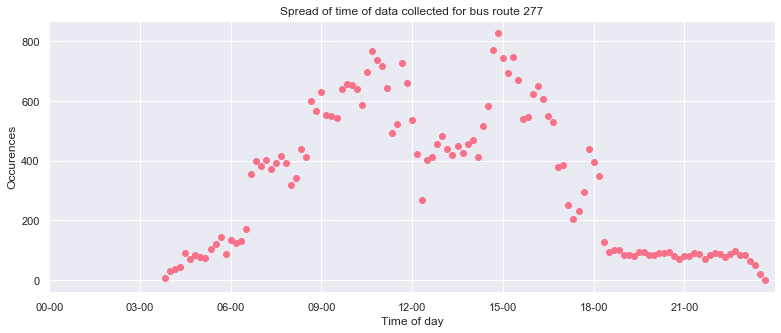

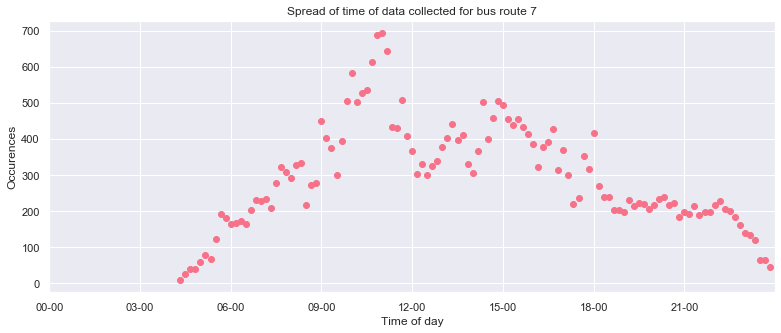

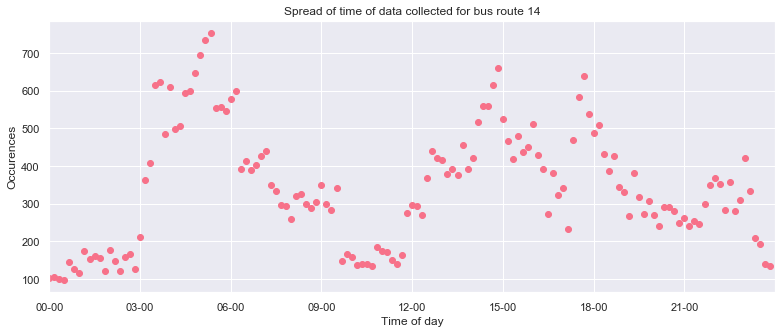

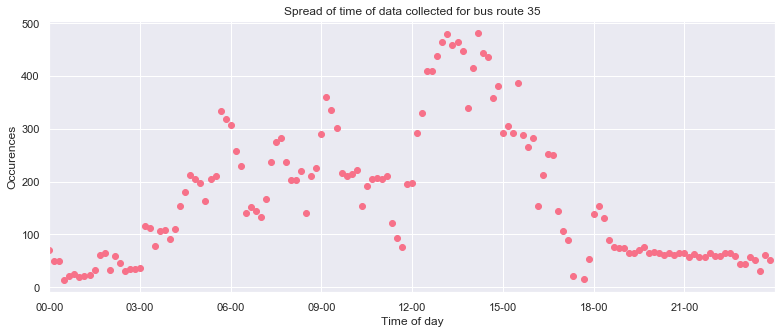

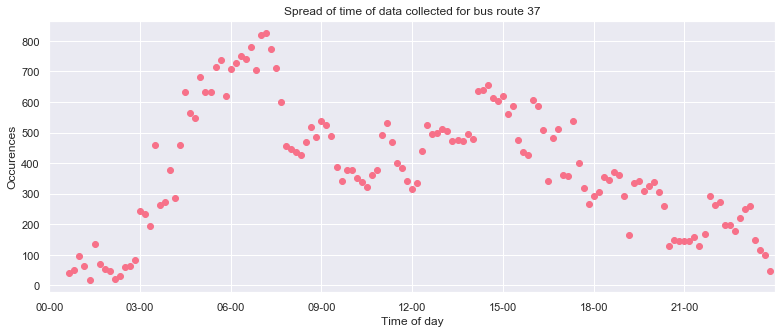

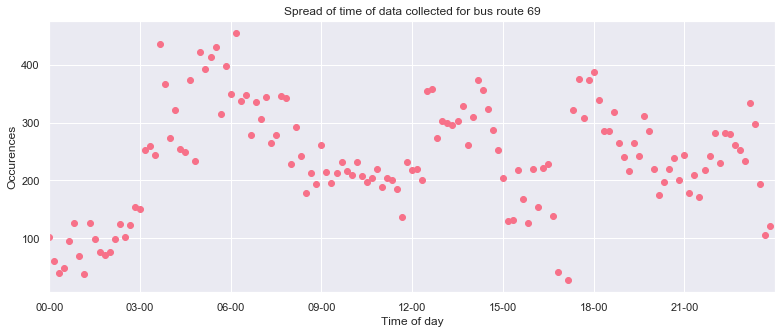

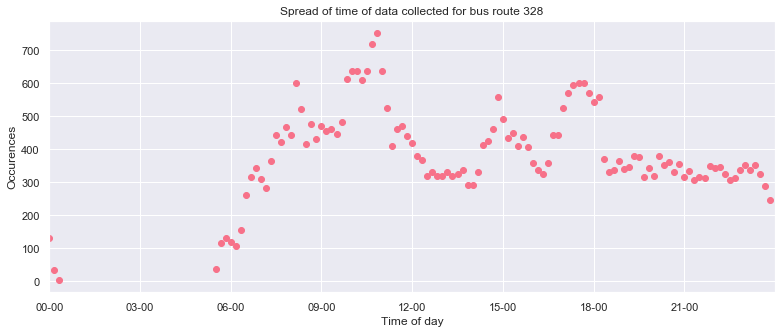

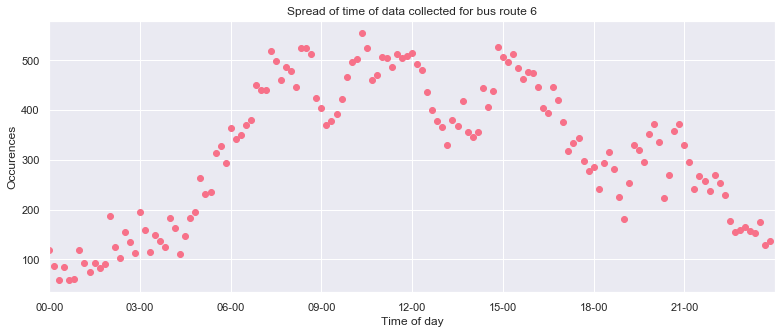

In [320]:
for route in routes:
    spread_of_time(data[route], route)

In [321]:
def spread_of_day_of_week(df, route):

    day_of_week = [x[:10] for x in df['expected_arrival']]
    day_of_week = [dt.datetime.strptime(date, '%Y-%m-%d') for date in day_of_week]

    day_of_week = [calendar.day_name[date.weekday()] for date in day_of_week]
    for_aggr = df.assign(day_of_week = day_of_week)
    for_aggr = for_aggr.groupby('day_of_week').count().reset_index()

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(for_aggr['day_of_week'], for_aggr['bus_stop_name'])
    ax.set_title("Spread of days of the week for data collected for route {}".format(route))
    ax.set_ylim(0)
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Occurences")
    plt.show()

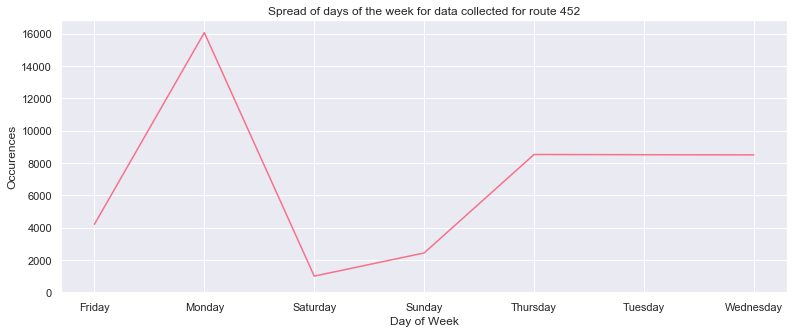

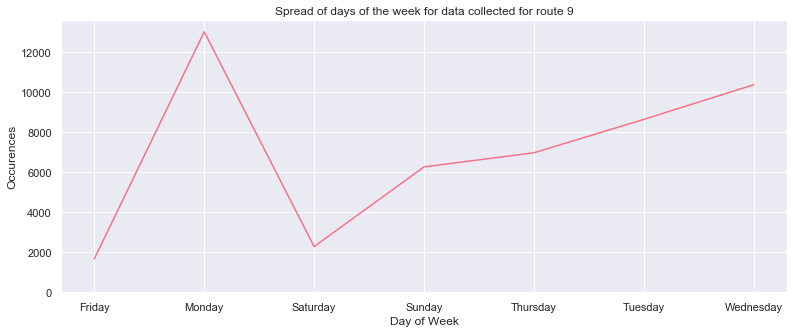

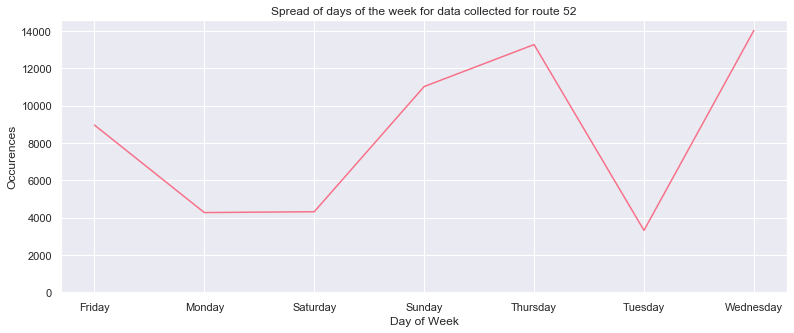

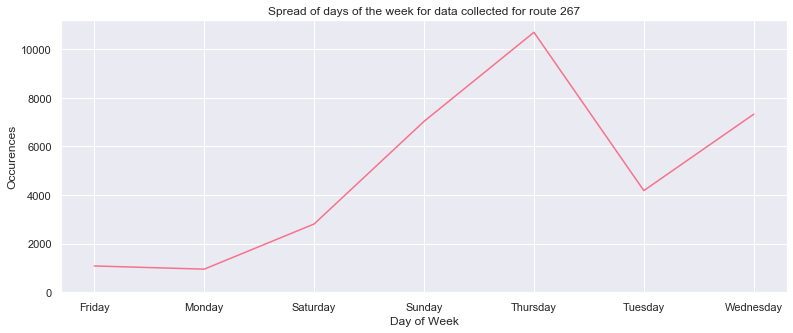

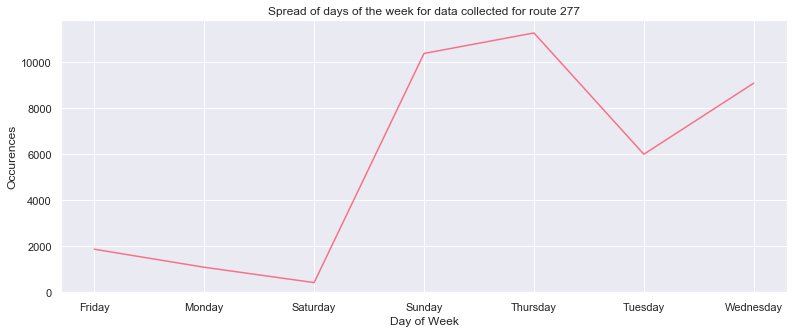

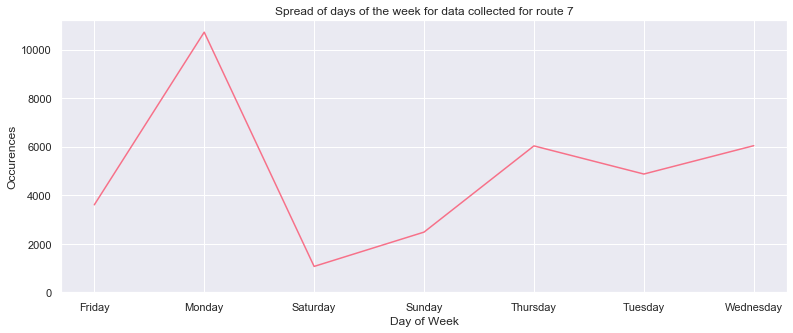

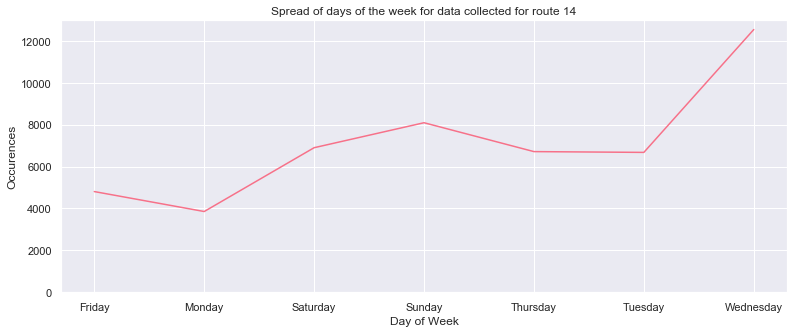

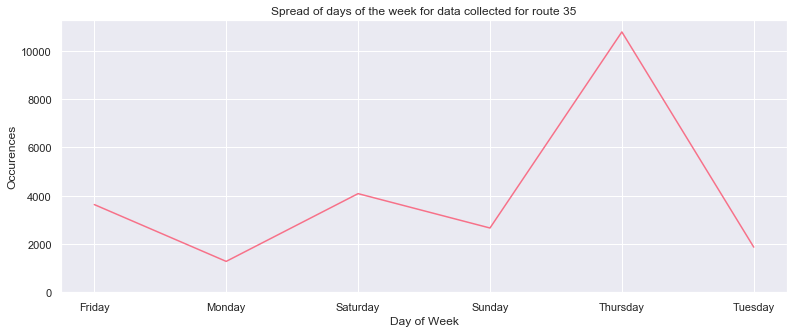

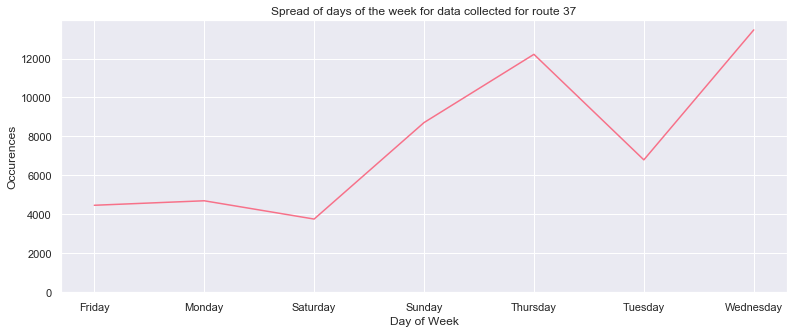

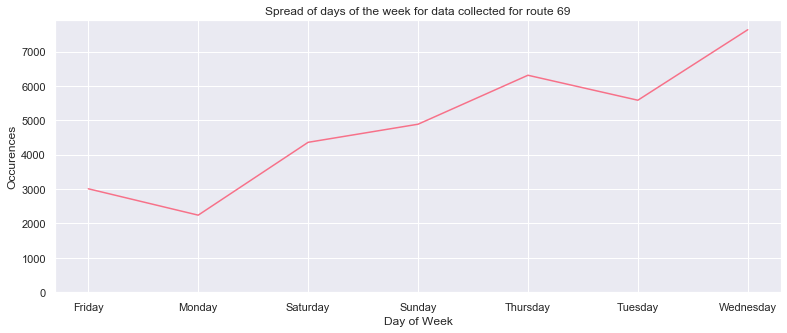

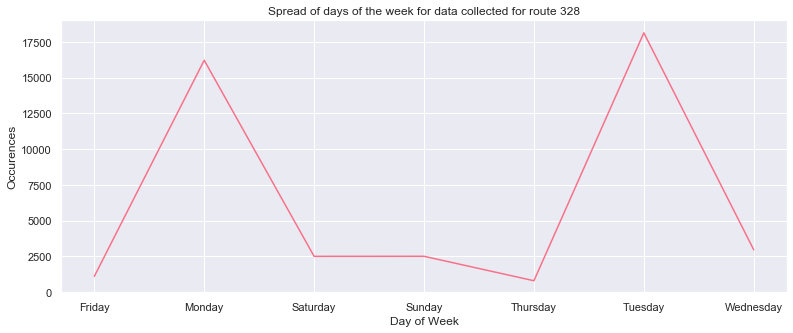

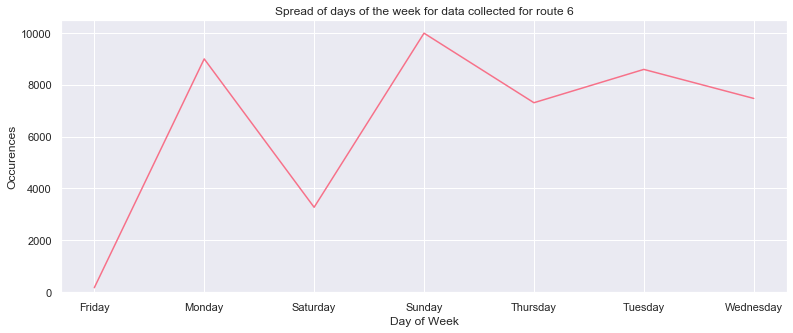

In [322]:
# Want x axis to have day of week in order from Monday - Sunday
for route in routes:
    spread_of_day_of_week(data[route], route)

# Data Analytics

## Helper Functions

In [323]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time
    
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]
cs = [colours[i] for i in range(len(colours))]

In [251]:
def get_times_between_two_stops(stop_a, stop_b, b_id):
    
    """
    journey_times 
        - is a list of all journey times for a bus from stop a to stop b
    time_of_day_grouped 
        - is a list of lists where each sublist represents a time period of the day
        - each sublist contains the journey times for a bus for that time period
    labels
        - is a list of all colour codes for every journey from stop a to stop b
        - e.g. [1,3,2] represents 3 journeys, where the 1st journey was in the time period 03-06
    """

    journey_times = []
    time_of_day_grouped = [[] for i in range (0, 8)]
    labels = []

    a = time.time()
    for i, journey in stop_a.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
        match_id = bus_id + '_' + b_id + '_' + date + '_' + direction + '_'
        start = convert_time_to_datetime(journey['expected_arrival'])
        for j, match in stop_b.iterrows():
            [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
            end = convert_time_to_datetime(match['expected_arrival'])
            if match['vehicle_id'].startswith(match_id):
                # Error in some of the data where trip num doesn't match so need to check that the travel time
                # is within a reasonable time period
                
                # TODO: Need to make a note of how long a journey time I'm giving these journeys between bus stops
                # Should decide how many bus stops back I should look to predict journey times of a bus
                # E.g. if All Souls Avenue is 7 stops behind Nottinghill Gate Station, I make it standard for all predictions
                # Again could use this as another hyparameter -> see how many stations back I can go before it becomes inaccurate?
                
                if (end - start < dt.timedelta(minutes = 40)) & (end - start > dt.timedelta(minutes = 0)):
                    diff = end - start
                    journey_times.append(diff)
                    section_of_day = get_time_of_day_group(match['expected_arrival'])
                    labels.append(section_of_day)
                    flt = diff.total_seconds() / 60
                    time_of_day_grouped[section_of_day].append(flt)
                    break

    print("Time taken: ", (time.time() - a))
    for i, group in enumerate(time_of_day_grouped):
        if len(group) == 0:
            time_of_day_grouped[i].append(np.nan)
    
    return journey_times, time_of_day_grouped, labels

In [244]:
def calc_info_for_graphs(journey_times):
    """
    travel_times 
        - is a list of all journey times for a bus from stop a to stop b converted into minutes
    avg_time
        - is the average amount of time for a journey from stop a to stop b across all time periods (minutes)
    counts
        - is a list of the number of times each journey time occurs
        - e.g. a journey time of 16 minutes may occur 2 times.
    """
    
    travel_times = [(time.total_seconds() / 60) for time in journey_times]
    avg_time = sum(travel_times) / len(travel_times)
    counts = [journey_times.count(elem) for elem in journey_times]
    return travel_times, avg_time, counts

In [245]:
def graph_travel_times(travel_times, avg_time, counts, stop_a, stop_b, route):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.scatter(travel_times, counts)
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {}".format(route, stop_a, stop_b))
    ax.legend()
    plt.show()

In [246]:
def graph_travel_by_time_of_day(route, stop_a, stop_b, travel_times, counts, labels, avg_time):
    fig, ax = plt.subplots(figsize=(15,6))
    sctr = ax.scatter(travel_times, counts, c=labels, cmap=matplotlib.colors.ListedColormap(cs))
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    ax.legend()

    # Can't get ticks to show properly on the colour bar maybe because there is no data for 00-03?
    cbar = fig.colorbar(sctr)
    cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
    cbar.set_ticklabels(colour_to_time_label)
    cbar.ax.set_title("Time of day")

    plt.show()

In [247]:
def graph_travel_by_time_of_day_2(time_of_day_grouped, avg_time, route, stop_a, stop_b):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Travel Time (minutes)")

    for x, y in zip(colour_to_time_label, time_of_day_grouped):
        ax.scatter([x] * len(y), y)

    ax.plot(colour_to_time_label, [avg_time] * len(colour_to_time_label), 'k--', label='average time')
    ax.set_xticklabels(colour_to_time_label)
    ax.legend()
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    plt.show()

## Historical Average Models

### Try to see if I can get the average time taken for a bus to travel from "Battersea Park Station" to "Vauxhall Bus Station" and (inbound) for bus 452

In [248]:
b_452 = data["452"]
vauxhall = b_452.loc[(b_452['bus_stop_name'] == 'Vauxhall Bus Station') & (b_452['direction'] == 'in')]
[_, vauxhall_id, _, _, _] = vauxhall.iloc[0]['vehicle_id'].split('_')
print(vauxhall.shape)
print(vauxhall_id)
vauxhall.head()

(394, 5)
490000247G1


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
11,Vauxhall Bus Station,2020-04-02 17:07:31,20189_490000247G1_2020-04-02_in_2,2020-04-02 16:49:18,in
48,Vauxhall Bus Station,2020-03-30 05:52:51,20191_490000247G1_2020-03-30_in_0,2020-03-30 05:28:43,in
76,Vauxhall Bus Station,2020-03-30 07:11:46,20310_490000247G1_2020-03-30_in_0,2020-03-30 06:43:43,in
151,Vauxhall Bus Station,2020-04-02 22:51:27,20199_490000247G1_2020-04-02_in_8,2020-04-02 22:51:37,in
292,Vauxhall Bus Station,2020-04-02 22:39:01,20278_490000247G1_2020-04-02_in_7,2020-04-02 22:36:37,in


In [249]:
battersea_prk_st = b_452.loc[(b_452['bus_stop_name'] == 'Battersea Park Station') & (b_452['direction'] == 'in')]
[_, battersea_prk_st_id, _, _, _] = battersea_prk_st.iloc[0]['vehicle_id'].split('_')
print(battersea_prk_st.shape)
print(battersea_prk_st_id)
battersea_prk_st.head()

(410, 5)
490G01016A


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
12,Battersea Park Station,2020-04-02 13:18:42,20189_490G01016A_2020-04-02_in_0,2020-04-02 13:16:44,in
13,Battersea Park Station,2020-04-01 10:27:00,20271_490G01016A_2020-04-01_in_0,2020-04-01 10:26:42,in
34,Battersea Park Station,2020-04-01 09:53:39,20196_490G01016A_2020-04-01_in_0,2020-04-01 09:53:03,in
37,Battersea Park Station,2020-04-06 07:36:56,20314_490G01016A_2020-04-06_in_1,2020-04-06 07:27:02,in
84,Battersea Park Station,2020-04-02 05:41:12,20193_490G01016A_2020-04-02_in_0,2020-04-02 05:34:44,in


In [252]:
journey_times_bv452, time_of_day_grouped_bv452, labels_bv452 = get_times_between_two_stops(battersea_prk_st, vauxhall, vauxhall_id)
travel_times_bv452, avg_time_bv452, counts_bv452 = calc_info_for_graphs(journey_times_bv452)
print("Average travel time between Vauxhall Bus Station and Battersea Park Station is {} minutes".format(avg_time_bv452))

Time taken:  19.77879309654236
Average travel time between Vauxhall Bus Station and Battersea Park Station is 14.583976124885224 minutes


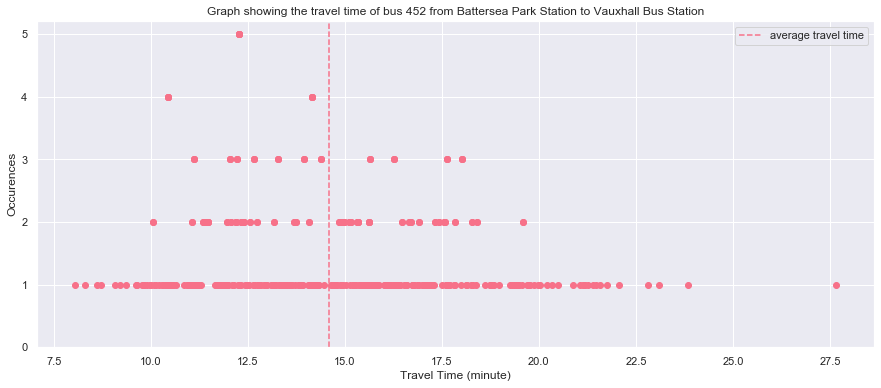

In [253]:
graph_travel_times(travel_times_bv452, avg_time_bv452, counts_bv452, "Battersea Park Station", "Vauxhall Bus Station", "452")

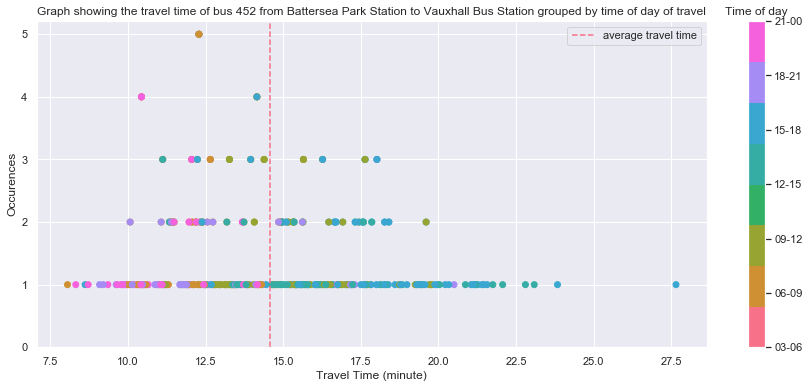

In [254]:
# labels for colour bar don't match because there is no information for 00-03
graph_travel_by_time_of_day("452", "Battersea Park Station", "Vauxhall Bus Station", travel_times_bv452, counts_bv452, labels_bv452, avg_time_bv452)

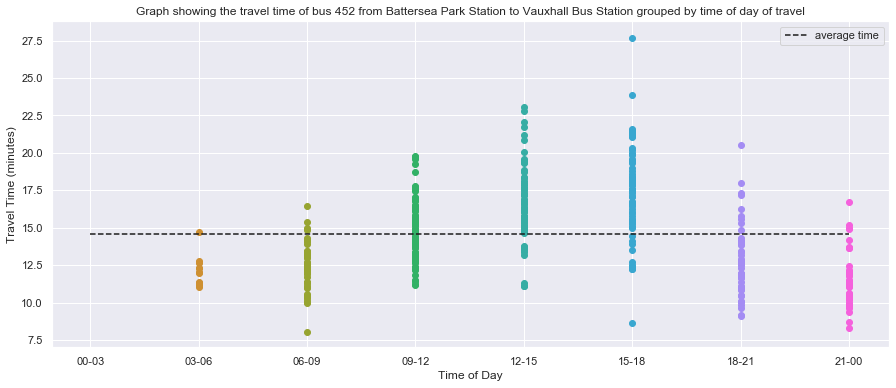

In [255]:
graph_travel_by_time_of_day_2(time_of_day_grouped_bv452, avg_time_bv452, "452", "Battersea Park Station", "Vauxhall Bus Station")

### Try to see if I can get the average time taken for a bus to travel from "All Souls Avenue" to "Nottinghill Gate Station" (outbound) for bus 52

In [256]:
b_52 = data["52"]
ntg_stn = b_52.loc[(b_52['bus_stop_name'] == 'Notting Hill Gate Station') & (b_52['direction'] == 'out')]
[_, ntg_stn_id, _, _, _] = ntg_stn.iloc[0]['vehicle_id'].split('_')
print(ntg_stn.shape)
print(ntg_stn_id)
ntg_stn.head()

(568, 5)
490000167G


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
106,Notting Hill Gate Station,2020-03-11 10:51:36,10805_490000167G_2020-03-11_out_0,2020-03-11 10:51:46,out
222,Notting Hill Gate Station,2020-04-01 20:38:13,11741_490000167G_2020-04-01_out_2,2020-04-01 20:33:12,out
310,Notting Hill Gate Station,2020-04-05 15:45:34,10627_490000167G_2020-04-05_out_0,2020-04-05 15:41:18,out
385,Notting Hill Gate Station,2020-04-02 10:17:57,19407_490000167G_2020-04-02_out_3,2020-04-02 09:55:17,out
495,Notting Hill Gate Station,2020-04-01 11:46:02,10509_490000167G_2020-04-01_out_0,2020-04-01 11:36:42,out


In [257]:
all_souls_avn = b_52.loc[(b_52['bus_stop_name'] == 'All Souls Avenue') & (b_52['direction'] == 'out')]
[_, all_souls_avn_id, _, _, _] = all_souls_avn.iloc[0]['vehicle_id'].split('_')
print(all_souls_avn.shape)
print(all_souls_avn_id)
all_souls_avn.head()

(543, 5)
490003256N


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
6,All Souls Avenue,2020-04-05 16:04:21,10292_490003256N_2020-04-05_out_0,2020-04-05 16:02:45,out
70,All Souls Avenue,2020-04-02 19:46:21,11741_490003256N_2020-04-02_out_2,2020-04-02 19:46:08,out
75,All Souls Avenue,2020-04-02 08:19:56,19643_490003256N_2020-04-02_out_2,2020-04-02 08:16:45,out
104,All Souls Avenue,2020-04-06 05:22:11,11473_490003256N_2020-04-06_out_0,2020-04-06 05:20:17,out
128,All Souls Avenue,2020-03-27 08:31:28,19667_490003256N_2020-03-27_out_0,2020-03-27 08:11:14,out


In [258]:
# It took a minute which is really long -> once I get psycopg2 installed could make queries
# to the database to get the information more easily maybe?
journey_times_na52, time_of_day_grouped_na52, labels_na52 = get_times_between_two_stops(all_souls_avn, ntg_stn, ntg_stn_id)
travel_times_na52, avg_time_na52, counts_na52 = calc_info_for_graphs(journey_times_na52)
print("Average travel time between Nottinghill Gate Station and All Souls Avenue is {} minutes".format(avg_time_na52))

Time taken:  22.964514017105103
Average travel time between Nottinghill Gate Station and All Souls Avenue is 15.170405310971352 minutes


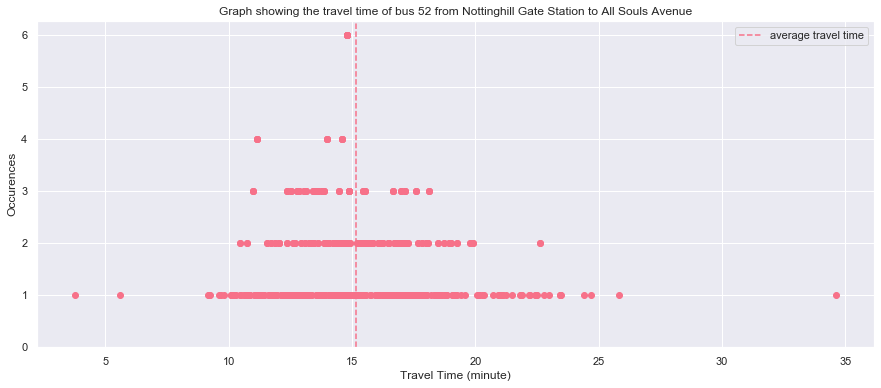

In [259]:
graph_travel_times(travel_times_na52, avg_time_na52, counts_na52, "Nottinghill Gate Station", "All Souls Avenue", "52")

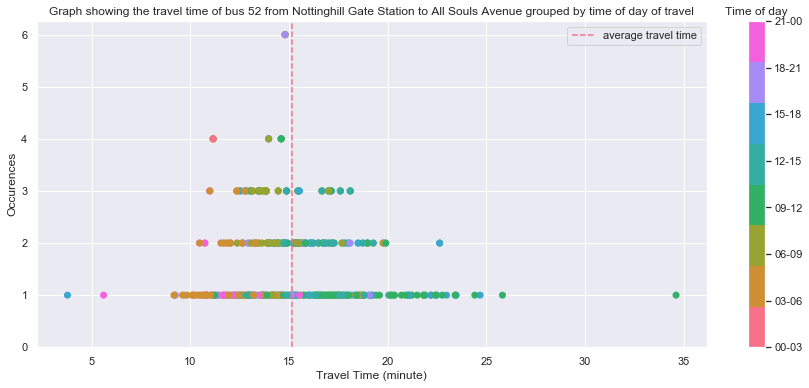

In [260]:
graph_travel_by_time_of_day("52", "Nottinghill Gate Station", "All Souls Avenue", travel_times_na52, counts_na52, labels_na52, avg_time_na52)

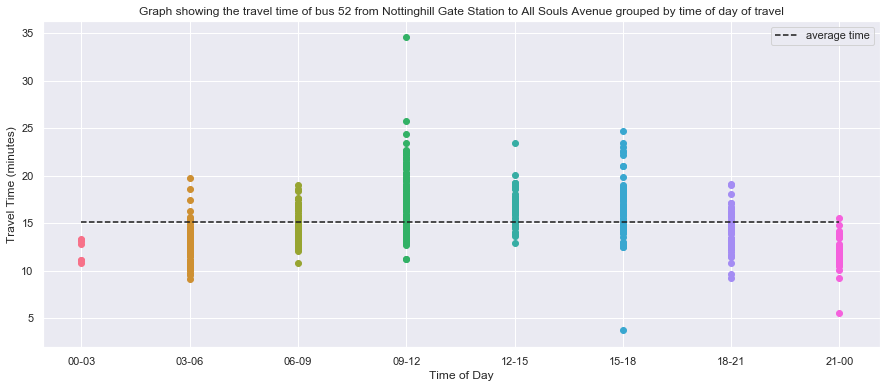

In [261]:
graph_travel_by_time_of_day_2(time_of_day_grouped_na52, avg_time_na52, "52", "Nottinghill Gate Station", "All Souls Avenue")

### Try to take recent information into account. E.g. Use journey times from the last hour to predict the journey time now -> for All Souls Avenue and Nottinghill Gate Station Route 52

If a bus left All Souls Avenue at time X, look at the other buses that have left All Souls Avenue and arrived at Nottinghill Gate Station in the past 2 hours, and then take the average of those as the predicted time.

Could weight it so that the journey times in the past 20 min weigh more than the journey times in the past hour and then the journey times in the hour previous weighs even less, but they all contribute to the prediction

In [262]:
def get_times_past_2_hours(stop_a, stop_b, a_id, req_time):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past 2 hours of the request time.
    left_journeys 
        - is a list of matching bus details for vehicles leaving from stop a
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past 2 hours of the request time.
    """

    journey_times = []
    left_journeys = []
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    print("REQ TIME: ", req_time)

    a = time.time()
    for i, journey in stop_b.iterrows():
        arrived = journey['expected_arrival']
        arr_dt = convert_time_to_datetime(arrived)
        past_2_hours = req_time - dt.timedelta(hours = 2)
        if (arr_dt > past_2_hours) & (arr_dt < req_time):
            [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
            match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_' + num_trip
            for j, match in stop_a.iterrows():
                [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
                if match['vehicle_id'].startswith(match_id):
                    leave_dt = convert_time_to_datetime(match['expected_arrival'])
                    journey_time = arr_dt - leave_dt
                    
                    if journey_time > dt.timedelta(minutes = 0):
                        left_journeys.append(match)
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        

    print("Time taken: ", (time.time() - a))
    
    return left_journeys, arrived_journeys, journey_times

In [263]:
def predict_journey_time(req_time, stop_a, stop_b, stop_a_id):
    left, arrived, journey_times = get_times_past_2_hours(stop_a, stop_b, stop_a_id, req_time)
    pred = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["expected_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += (weight * journey_time)
    return pred

In [264]:
req_time = "2020-04-16 04:51:36"
weights = {"10": 0.6, "20": 0.25, "40": 0.1, "80": 0.04, "120": 0.01}
pred = predict_journey_time(req_time, all_souls_avn, ntg_stn, all_souls_avn_id)

# If I request the arrival time of a bus at Nottinghill Gate Station at req_time, 
# what is the predicted arrival time?
print("The predicted journey time for a bus is {:.2f} minutes".format(pred / 60))

REQ TIME:  2020-04-16 04:51:36
Time taken:  0.615570068359375
The predicted journey time for a bus is 12.54 minutes


Now try to get predicted arrival time
- estimated_leaving_time = minus the predicted journey time from the request time
- Find the the bus leaving from All Souls Avenue that is leaving as close to the estimated_leaving_time as possible (after or equal to this time)
- Add the journey time back on to the leaving time and this should be the estimated arrival time.
- Then can check in the database when this vehicle actually arrived.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds.

In [265]:
est_leaving_time = convert_time_to_datetime(req_time) - dt.timedelta(seconds = pred)
print(est_leaving_time)

def pred_arrival_time(est_leaving_time, leave_stop, pred):
    # finds the nearest bus and adds the predicted journey time onto its leaving time
    bus = 0

    # If there is no bus leaving within 15 minutes, assume no bus exists at this time
    secs = 120
    while secs < (15 * 60):
        for i, item in leave_stop.iterrows():
            leave_time = convert_time_to_datetime(item['expected_arrival'])
            diff = leave_time - est_leaving_time
            # give 30 seconds leeway for arriving and loading/unloading passengers
            if (diff >= dt.timedelta(seconds = -30)) & (diff < dt.timedelta(seconds = secs)):
                print(leave_time)
                bus = leave_time + dt.timedelta(seconds = (pred + 30))
                return bus, item
        secs += 30
                
    print("There is no bus due")    
    return bus, []
            
pred_arr, bus_to_track = pred_arrival_time(est_leaving_time, all_souls_avn, pred)
print("The predicted arrival time at Nottinghill Gate Station for a bus requested at {} is {}".format(req_time, pred_arr))

2020-04-16 04:39:03.450000
2020-04-16 04:39:01
The predicted arrival time at Nottinghill Gate Station for a bus requested at 2020-04-16 04:51:36 is 2020-04-16 04:52:03.550000


In [266]:
# Returns None if cannot find matching vehicle
def eval_prediction(bus_to_track, pred_arr, arr_stop, arr_id):
    for i, item in arr_stop.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = bus_to_track['vehicle_id'].split('_')
        match_id = bus_id + '_' + arr_id + '_' + date + '_' + direction + '_' + num_trip
        if match_id == item['vehicle_id']:
            print("Actual arrival time is {}".format(item['expected_arrival']))
            print("Predicted arrival time is {}".format(pred_arr))
            return item['expected_arrival']

actual = eval_prediction(bus_to_track, pred_arr, ntg_stn, ntg_stn_id)

Actual arrival time is 2020-04-16 04:50:10
Predicted arrival time is 2020-04-16 04:52:03.550000


Now do the same as above for lots of different request times and then get the mean squared error between the actual and predicted?

In [267]:
def pred_eval_arrival_times(req_time, stop_a, stop_b, a_id, b_id):
    a_name = stop_a['bus_stop_name'].unique()[0]
    b_name = stop_b['bus_stop_name'].unique()[0]
    pred = predict_journey_time(req_time, stop_a, stop_b, a_id)

    # If I request the arrival time of a bus at Nottinghill Gate Station at req_time, 
    # what is the predicted arrival time?
    print("The predicted journey time for a bus from {} to {} is {:.2f} minutes".format(a_name, b_name, pred / 60))
    
    est_leaving_time = convert_time_to_datetime(req_time) - dt.timedelta(seconds = pred)
    print("The estimated leave time of a bus requested at {} is {}".format(req_time, est_leaving_time))
    pred_arr, bus_to_track = pred_arrival_time(est_leaving_time, stop_a, pred)
    if isinstance(bus_to_track, list):
        print("Cannot find correlating bus.")
        return pred_arr, 0
    print("The predicted arrival time at {} for a bus requested at {} is {}".format(b_name, req_time, pred_arr))
    actual_arr = eval_prediction(bus_to_track, pred_arr, stop_b, b_id)
    if actual_arr is None:
        return pred_arr, 0
    return pred_arr, actual_arr

Getting predicted arrival times for buses on route 52 on 16/04/20

In [268]:
preds_52_160420 = []
accs_52_160420 = []
req_times_52_160420 = ["2020-04-16 02:58:12", "2020-04-16 03:16:27", "2020-04-16 03:59:55", "2020-04-16 04:51:36", "2020-04-16 05:11:55","2020-04-16 05:52:43", "2020-04-16 06:07:01", "2020-04-16 06:43:22", "2020-04-16 06:59:11", "2020-04-16 07:17:02", "2020-04-16 08:00:22", "2020-04-16 08:33:18", "2020-04-16 09:10:54", "2020-04-16 09:48:37", "2020-04-16 10:02:43", "2020-04-16 10:49:21"]
req_timesx_52_160420 = []

for req_time in req_times_52_160420:
    p, a = pred_eval_arrival_times(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
    req_timesx_52_160420.append(req_time)
    preds_52_160420.append(p)
    accs_52_160420.append(a)

REQ TIME:  2020-04-16 02:58:12
Time taken:  0.09190607070922852
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 0.00 minutes
The estimated leave time of a bus requested at 2020-04-16 02:58:12 is 2020-04-16 02:58:12
There is no bus due
Cannot find correlating bus.
REQ TIME:  2020-04-16 03:16:27
Time taken:  0.14370298385620117
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 3.27 minutes
The estimated leave time of a bus requested at 2020-04-16 03:16:27 is 2020-04-16 03:13:10.500000
2020-04-16 03:17:18
The predicted arrival time at Notting Hill Gate Station for a bus requested at 2020-04-16 03:16:27 is 2020-04-16 03:21:04.500000
Actual arrival time is 2020-04-16 03:29:24
Predicted arrival time is 2020-04-16 03:21:04.500000
REQ TIME:  2020-04-16 03:59:55
Time taken:  1.0491869449615479
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 12.80 minutes
The estimated l

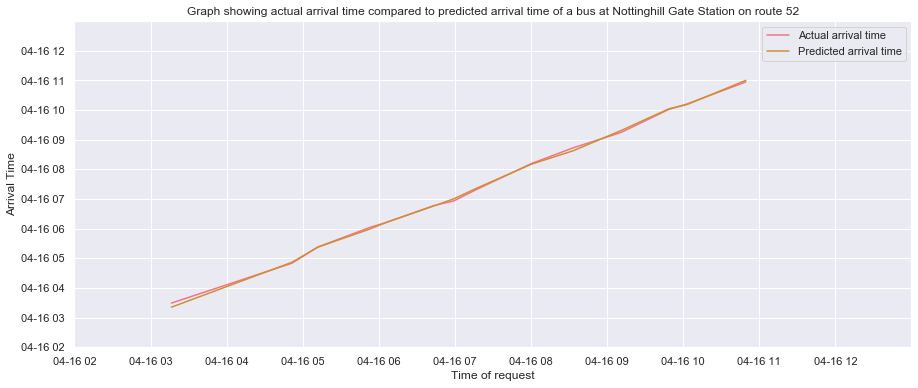

In [274]:
from sklearn.metrics import mean_squared_error

actual_52_160420 = [convert_time_to_datetime(a) for a in accs_52_160420]
times_52_160420 = [convert_time_to_datetime(t) for t in req_timesx_52_160420]

# mse = mean_squared_error(actual_52_160420, preds_52_160420)
# print("Mean Squared Error: ", mse)

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(times_52_160420, actual_52_160420, label="Actual arrival time")
ax.plot(times_52_160420, preds_52_160420, label="Predicted arrival time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Arrival Time")
ax.set_ylim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 4, 16, 12, 59, 59)])
ax.set_xlim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 4, 16, 12, 59, 59)])
ax.set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax.legend()
plt.show()

Getting predicted arrival times for buses on route 52 on 19/04/20

In [270]:
preds_52_190420 = []
accs_52_190420 = []
req_times_52_190420 = ["2020-04-19 08:59:59", "2020-04-19 09:13:27", "2020-04-19 09:48:55", "2020-04-19 10:15:27", "2020-04-19 10:38:41","2020-04-19 11:14:43", "2020-04-19 11:22:01", "2020-04-19 12:28:22", "2020-04-19 12:59:11", "2020-04-19 13:02:02", "2020-04-19 13:40:22", "2020-04-19 14:00:18", "2020-04-19 14:42:54", "2020-04-19 15:05:37", "2020-04-19 15:37:43", "2020-04-19 16:17:21", "2020-04-19 16:52:16", "2020-04-19 17:18:55", "2020-04-19 17:26:11", "2020-04-19 18:00:00", "2020-04-19 18:42:15", "2020-04-19 18:56:19", "2020-04-19 19:04:09", "2020-04-19 19:32:07", "2020-04-19 19:55:22", "2020-04-19 20:19:23", "2020-04-19 20:46:32", "2020-04-19 21:09:21", "2020-04-19 21:32:56", "2020-04-19 21:54:12", "2020-04-19 22:04:00"]
req_timesx_52_190420 = []
for req_time in req_times_52_190420:
    p, a = pred_eval_arrival_times(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
    req_timesx_52_190420.append(req_time)
    preds_52_190420.append(p)
    accs_52_190420.append(a)

REQ TIME:  2020-04-19 08:59:59
Time taken:  0.2369070053100586
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 7.57 minutes
The estimated leave time of a bus requested at 2020-04-19 08:59:59 is 2020-04-19 08:52:24.800000
2020-04-19 08:51:59
The predicted arrival time at Notting Hill Gate Station for a bus requested at 2020-04-19 08:59:59 is 2020-04-19 09:00:03.200000
Actual arrival time is 2020-04-19 09:05:25
Predicted arrival time is 2020-04-19 09:00:03.200000
REQ TIME:  2020-04-19 09:13:27
Time taken:  0.3449289798736572
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 9.32 minutes
The estimated leave time of a bus requested at 2020-04-19 09:13:27 is 2020-04-19 09:04:07.700000
2020-04-19 09:09:14
The predicted arrival time at Notting Hill Gate Station for a bus requested at 2020-04-19 09:13:27 is 2020-04-19 09:19:03.300000
Actual arrival time is 2020-04-19 09:22:16
Predicted arrival time is 2020-04-1

2020-04-19 16:42:50
The predicted arrival time at Notting Hill Gate Station for a bus requested at 2020-04-19 16:52:16 is 2020-04-19 16:59:27.920000
Actual arrival time is 2020-04-19 16:59:10
Predicted arrival time is 2020-04-19 16:59:27.920000
REQ TIME:  2020-04-19 17:18:55
Time taken:  0.6724898815155029
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 15.83 minutes
The estimated leave time of a bus requested at 2020-04-19 17:18:55 is 2020-04-19 17:03:05.320000
2020-04-19 17:09:34
The predicted arrival time at Notting Hill Gate Station for a bus requested at 2020-04-19 17:18:55 is 2020-04-19 17:25:53.680000
Actual arrival time is 2020-04-19 17:23:08
Predicted arrival time is 2020-04-19 17:25:53.680000
REQ TIME:  2020-04-19 17:26:11
Time taken:  0.6810781955718994
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 15.52 minutes
The estimated leave time of a bus requested at 2020-04-19 17:26:11 is 2020-04

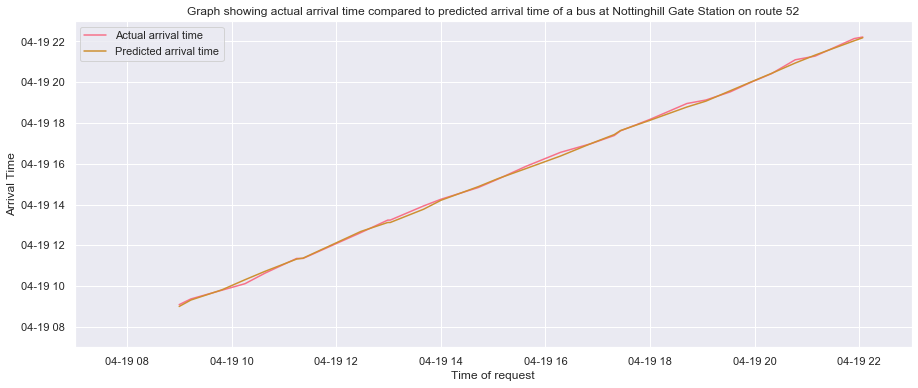

In [275]:
actual_52_190420 = [convert_time_to_datetime(a) for a in accs_52_190420]
times_52_190420 = [convert_time_to_datetime(t) for t in req_timesx_52_190420]

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(times_52_190420, actual_52_190420, label="Actual arrival time")
ax.plot(times_52_190420, preds_52_190420, label="Predicted arrival time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Arrival Time")
ax.set_ylim([dt.datetime(2020, 4, 19, 7), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax.set_xlim([dt.datetime(2020, 4, 19, 7), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax.set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax.legend()
plt.show()

# Could calculate MSE?

### Try to see if I can get the average time taken for a bus to travel from "Warwick Avenue Station" to "Trafalgar Square" (inbound) for bus 6

In [333]:
b_6 = data["6"]
warwick_avn = b_6.loc[(b_6['bus_stop_name'] == 'Warwick Avenue Station') & (b_6['direction'] == 'in')]
[_, warwick_avn_id, _, _, _] = warwick_avn.iloc[0]['vehicle_id'].split('_')
print(warwick_avn.shape)
print(warwick_avn_id)
warwick_avn.head()

(616, 5)
490000253H


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
28,Warwick Avenue Station,2020-04-25 10:08:40,10275_490000253H_2020-04-25_in_0,2020-04-25 10:06:38,in
59,Warwick Avenue Station,2020-04-25 10:13:14,10274_490000253H_2020-04-25_in_0,2020-04-25 10:13:07,in
154,Warwick Avenue Station,2020-04-25 10:21:14,19403_490000253H_2020-04-25_in_0,2020-04-25 10:21:34,in
224,Warwick Avenue Station,2020-04-25 10:29:16,19670_490000253H_2020-04-25_in_0,2020-04-25 10:17:25,in
293,Warwick Avenue Station,2020-04-25 10:37:58,10631_490000253H_2020-04-25_in_0,2020-04-25 10:37:39,in


In [334]:
trafalgar_sqr = b_6.loc[(b_6['bus_stop_name'] == 'Trafalgar Square') & (b_6['direction'] == 'in')]
[_, trafalgar_sqr_id, _, _, _] = trafalgar_sqr.iloc[0]['vehicle_id'].split('_')
print(trafalgar_sqr.shape)
print(trafalgar_sqr_id)
trafalgar_sqr.head()

(583, 5)
490013767B


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
37,Trafalgar Square,2020-04-25 10:07:12,9976_490013767B_2020-04-25_in_0,2020-04-25 10:05:00,in
156,Trafalgar Square,2020-04-25 10:21:05,19409_490013767B_2020-04-25_in_0,2020-04-25 10:17:56,in
217,Trafalgar Square,2020-04-25 10:26:56,10275_490013767B_2020-04-25_in_0,2020-04-25 10:26:16,in
252,Trafalgar Square,2020-04-25 10:32:56,10274_490013767B_2020-04-25_in_0,2020-04-25 10:28:50,in
315,Trafalgar Square,2020-04-25 10:38:26,19403_490013767B_2020-04-25_in_0,2020-04-25 10:33:30,in


In [335]:
journey_times_wt6, time_of_day_grouped_wt6, labels_wt6 = get_times_between_two_stops(warwick_avn, trafalgar_sqr, trafalgar_sqr_id)
travel_times_wt6, avg_time_wt6, counts_wt6 = calc_info_for_graphs(journey_times_wt6)
print("Average travel time between Warwick Avenue Station and Trafalgar Square is {} minutes".format(avg_time_wt6))

Time taken:  45.25194501876831
Average travel time between Warwick Avenue Station and Trafalgar Square is 20.482149712092134 minutes


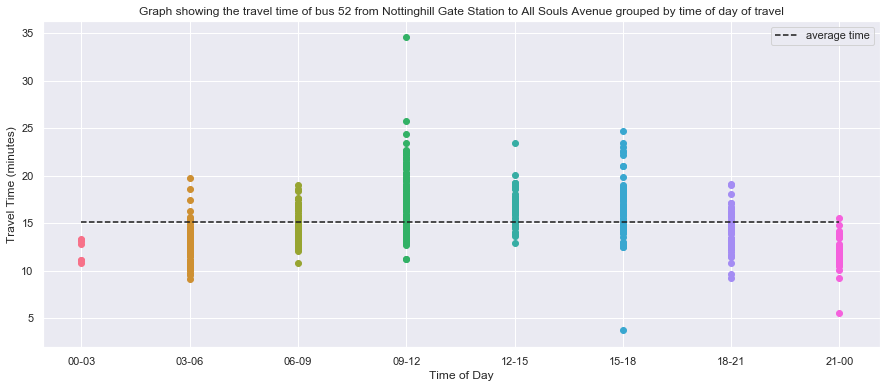

In [336]:
graph_travel_by_time_of_day_2(time_of_day_grouped_na52, avg_time_na52, "52", "Nottinghill Gate Station", "All Souls Avenue")

In [ ]:
preds_52_160420 = []
accs_52_160420 = []
req_times_52_160420 = ["2020-04-16 02:58:12", "2020-04-16 03:16:27", "2020-04-16 03:59:55", "2020-04-16 04:51:36", "2020-04-16 05:11:55","2020-04-16 05:52:43", "2020-04-16 06:07:01", "2020-04-16 06:43:22", "2020-04-16 06:59:11", "2020-04-16 07:17:02", "2020-04-16 08:00:22", "2020-04-16 08:33:18", "2020-04-16 09:10:54", "2020-04-16 09:48:37", "2020-04-16 10:02:43", "2020-04-16 10:49:21"]
req_timesx_52_160420 = []

for req_time in req_times_52_160420:
    p, a = pred_eval_arrival_times(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
    req_timesx_52_160420.append(req_time)
    preds_52_160420.append(p)
    accs_52_160420.append(a)

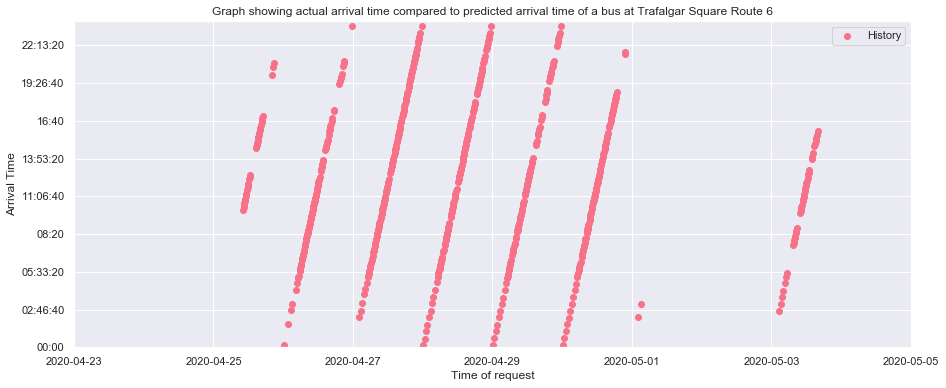

In [342]:
trafalgar_history = []
for i, item in trafalgar_sqr.iterrows():
    eta = convert_time_to_datetime(item.get('expected_arrival'))
    trafalgar_history.append(eta)
        
dates = [x.date() for x in trafalgar_history]
times = [x.time() for x in trafalgar_history]

fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(trafalgar_history, times, label="History")
ax.set_ylim([dt.time(0), dt.time(23,59,59)])
ax.set_xlim([dt.datetime(2020, 4, 23), dt.datetime(2020, 5, 5)])
ax.set_xlabel("Time of request")
ax.set_ylabel("Arrival Time")
ax.set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Trafalgar Square Route 6")
ax.legend()
plt.show()

In [294]:
actual_52_160420[0].date()

datetime.date(2020, 4, 16)

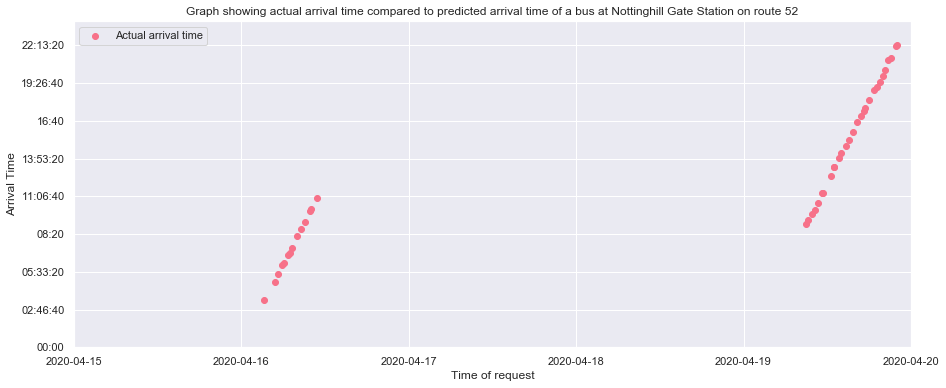

In [287]:
# Take away the date and give it an arbitrary date.
aggr_times = actual_52_160420 + actual_52_190420
aggr_times = [x.time() for x in aggr_times]

aggr_reqs = times_52_160420 + times_52_190420

fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(aggr_reqs, aggr_times, label="Actual arrival time")
ax.set_ylim([dt.time(0), dt.time(23,59,59)])
ax.set_xlim([dt.datetime(2020, 4, 15), dt.datetime(2020, 4, 20)])
ax.set_xlabel("Time of request")
ax.set_ylabel("Arrival Time")
ax.set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax.legend()
plt.show()

### Try a simple naive seasonal model -> We can plot the travel times of the training data then draw a line of best fit (i.e. form a linear regression model). Use this line of best fit to predict the travel time and then do the same for the test data and see error and accuracy?

If a bus left All Souls Avenue at time X, what time would it arrive at Nottinghill Gate Station?

[233.  91. 111. 152. 120.  67. 310.  94. 183.  66. 173.  72.  49.  64.
  48. 178. 104. 132. 220.  57.]
Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


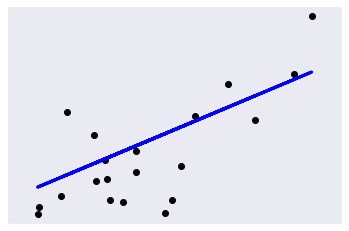

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

print(diabetes_y_test)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [33]:
journeys = []

conn = None
try:
    # This is in the docker container so might need to run this code in the container?
    conn = psycopg2.connect(host="db", database="postgres", user="postgres", password="example", port="5432")
    cursor = conn.cursor()
    sql_select = "SELECT * FROM bus_arrivals_52 WHERE expected_arrival LIKE 2020-04-19 11%"
    cursor.execute(sql_select)
    rows = cursor.fetchall()
    journeys.append(rows)
    sql_select = "SELECT * FROM bus_arrivals_52 WHERE expected_arrival LIKE 2020-04-19 10%"
    cursor.execute(sql_select)
    rows = cursor.fetchall()
    journeys.append(rows)
    sql_select = "SELECT * FROM bus_arrivals_52 WHERE expected_arrival LIKE 2020-04-19 9%"
    cursor.execute(sql_select)
    rows = cursor.fetchall()
    journeys.append(rows)
    conn.commit()
    cursor.close()
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

could not translate host name "db" to address: nodename nor servname provided, or not known



In [55]:
test = all_souls_avn[all_souls_avn['vehicle_id'] == "10292_490003256N_2020-04-05_out_0"]
test

,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
6,All Souls Avenue,2020-04-05 16:04:21,10292_490003256N_2020-04-05_out_0,2020-04-05 16:02:45,out
